In [243]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import os.path
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
import gpytorch
import copy
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib import colors

In [2]:
import sys
sys.path.append("../simplex/")
import utils
from simplex_helpers import volume_loss, complex_volume
import surfaces

sys.path.append("../simplex/models/")
from basic_mlps import BasicNet, BasicSimplex
from simplex_models import SimplexNet, Simplex
from preresnet import PreResNetSimplex




In [3]:
def compute_loss_surface(model, train_x, train_y, v1, v2,
                        loss, n_pts=50, range_=10.):
    
    start_pars = model.state_dict()
    vec_lenx = torch.linspace(-range_.item(), range_.item(), n_pts)
    vec_leny = torch.linspace(-range_.item(), range_.item(), n_pts)
    ## init loss surface and the vector multipliers ##
    loss_surf = torch.zeros(n_pts, n_pts)
    with torch.no_grad():
        ## loop and get loss at each point ##
        for ii in range(n_pts):
            for jj in range(n_pts):
                perturb = v1.mul(vec_lenx[ii]) + v2.mul(vec_leny[jj])
                # print(perturb.shape)
                perturb = utils.unflatten_like(perturb.t(), model.parameters())
                for i, par in enumerate(model.parameters()):
                    par.data = par.data + perturb[i].to(par.device)

                loss_surf[ii, jj] = loss(model(train_x), train_y)

                model.load_state_dict(start_pars)

    X, Y = np.meshgrid(vec_lenx, vec_leny)
    return X, Y, loss_surf

# Setup Functions/Classes

In [4]:
def twospirals(n_points, noise=.3, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [130]:
noise = 1.

In [156]:

X, Y = twospirals(50, noise=noise)
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

X, Y = twospirals(100, noise=noise)
test_x = torch.FloatTensor(X)
test_y = torch.FloatTensor(Y).unsqueeze(-1)

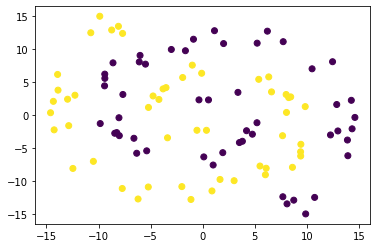

In [157]:
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y[:,0])

In [158]:
train_x, train_y = train_x.cuda(), train_y.cuda()
test_x, test_y = test_x.cuda(), test_y.cuda()

In [159]:
def trainer(model, train_x, train_y, reg_par=1e-5, niters=500,
           print_every=100, print_=False, n_samples=5):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    loss_func = torch.nn.BCEWithLogitsLoss()

    for step in range(niters):
        optimizer.zero_grad()
        vol = model.total_volume() + 1e-4
#         print(vol)
        acc_loss = 0
        for ii in range(n_samples):
            outputs = model(train_x)
            acc_loss += loss_func(outputs, train_y)
        loss = acc_loss - reg_par * vol.log()
        if print_:
            if step % print_every == 0:
                print(acc_loss.item())
                print(vol.item())
                print("\n") 

        loss.backward()
        optimizer.step()

## Fix the Regularization Parameters

In [160]:
LMBD = 3.

In [161]:
reg_pars = [0.]
for ii in range(2, 5):
    fix_pts = [True]*(ii)
    start_vert = len(fix_pts)

    out_dim = 1
    temp = SimplexNet(out_dim, BasicSimplex, n_vert=start_vert,
                           fix_points=fix_pts,
                          architecture_kwargs=arch_kwargs)
    temp = temp.cuda()

    log_vol = (temp.total_volume() + 1e-4).log()

    reg_pars.append(max(float(LMBD)/log_vol, 1e-8).item())

In [162]:
reg_pars

[0.0, 0.6154012680053711, 0.3698790669441223, 0.2894383668899536]

## Train

In [163]:
fix_pts = [False]
start_vert = len(fix_pts)

total_verts = 4

out_dim = 1
arch_kwargs = {"in_dim":2, "hidden_size":25,
                     "activation":torch.nn.ReLU(), "bias":True}

simplex_model = SimplexNet(out_dim, BasicSimplex, n_vert=start_vert,
                       fix_points=fix_pts,
                      architecture_kwargs=arch_kwargs)
simplex_model = simplex_model.cuda()

In [164]:
base_model = BasicNet(simplex_model.n_output, **simplex_model.architecture_kwargs)
base_model = base_model.cuda()

In [165]:
trainer(simplex_model, train_x, train_y, reg_par=reg_pars[0], print_=False, n_samples=1, niters=200)

In [166]:
for ii in range(1, total_verts):
    simplex_model.add_vert()
    simplex_model = simplex_model.cuda()
    trainer(simplex_model, train_x, train_y, reg_par=0., print_=False,
           niters=100)

## Plot

In [167]:
def surf_runner(anchor,base1,base2):
    v1, v2 = surfaces.get_basis(simplex_model, anchor=anchor, base1=base1, base2=base2)

    par_vecs = simplex_model.par_vectors()
    v1 = v1.to(par_vecs.device)
    v2 = v2.to(par_vecs.device)

    vec = (par_vecs[anchor, :] - par_vecs[base1, :])

    base_model = BasicNet(simplex_model.n_output, **simplex_model.architecture_kwargs).cuda()

    center_pars = par_vecs[[anchor, base1, base2], :].mean(0).unsqueeze(0)
    utils.assign_pars(center_pars, base_model)

    anchor_pars = torch.cat((simplex_model.n_vert * [center_pars]))
    anchor_diffs = (par_vecs - anchor_pars)

    diff_v1_projs = anchor_diffs.matmul(v1)
    diff_v2_projs = anchor_diffs.matmul(v2)

    range_ = torch.max((diff_v1_projs).abs().max(), (diff_v2_projs).abs().max()) + 1.
    
    X, Y, surf = compute_loss_surface(base_model, train_x, train_y, 
                                  v1, v2, torch.nn.BCEWithLogitsLoss(),
                                 range_=range_, n_pts=15)

    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    
    return X, Y, surf, diff_v1_projs, diff_v2_projs

In [168]:
def cutter(surf, cutoff=0.3):
    cutoff_surf = surf.clone()
    cutoff_surf[cutoff_surf > cutoff] = cutoff
    return cutoff_surf.detach().cpu()

In [169]:
X012, Y012, surf012, x012, y012 = surf_runner(0,1,2)
X013, Y013, surf013, x013, y013 = surf_runner(0,1,3)
X023, Y023, surf023, x023, y023 = surf_runner(0,2,3)
X123, Y123, surf123, x123, y123 = surf_runner(1,2,3)

In [170]:
cutoff012 = cutter(surf012)
cutoff013 = cutter(surf013)
cutoff023 = cutter(surf023)
cutoff123 = cutter(surf123)

In [171]:
def surf_plotter(X, Y, surf, x, y, anchor, base1, base2, ax):
    contour_ = ax.contourf(X, Y, surf.t(), levels=25,
                      cmap='RdYlBu_r')
    # fig.colorbar(contour_)
    keepers = [anchor, base1, base2]
    x = x.detach().cpu()
    y = y.cpu().detach()

    color='black'
    ax.scatter(x=x[keepers], y=y[keepers],
                color=[color], s=10)

    xoffsets = [-.85, .25, -.5]
    yoffsets = [-.75, .0, 0.25]

    labels = [r'$w_' + str(ii) + '$' for ii in range(total_verts)]
    for ii, pt in enumerate(keepers):
        ax.annotate(labels[pt], (x[pt]+xoffsets[ii], y[pt]+yoffsets[ii]), size=18,
                   color=color)


    lw=1.
    for pt1 in keepers:
        for pt2 in keepers:
            ax.plot([x[pt1], x[pt2]], [y[pt1], y[pt2]], color=color,
                    linewidth=lw)

    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
    return contour_

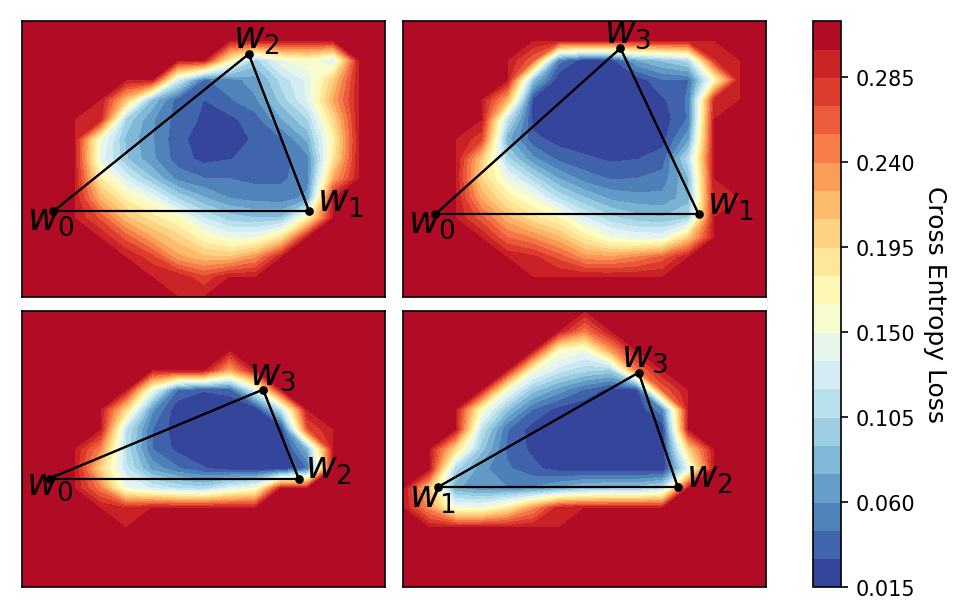

In [172]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5), dpi=150)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
contour_ = surf_plotter(X012, Y012, cutoff012, x012, y012, 0, 1, 2, ax[0,0])
surf_plotter(X013, Y013, cutoff013, x013, y013, 0, 1, 3, ax[0,1])
surf_plotter(X023, Y023, cutoff023, x023, y023, 0, 2, 3, ax[1,0])
surf_plotter(X123, Y123, cutoff123, x123, y123, 1,2,3, ax[1,1])
cbar = fig.colorbar(contour_, ax=ax.ravel().tolist())
cbar.set_label("Cross Entropy Loss", rotation=270, labelpad=15., fontsize=12)
plt.savefig("./two_spirals_example.pdf", bbox_inches='tight')
fig.show()

## Check What The Solutions Look Like

In [193]:
buffer = 3.
h = 0.05
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [194]:
xx.shape

(718, 705)

### For testing the vertices

In [195]:
mdls = [0, 1, 2, 3]
n_mdls = len(mdls)
accs = torch.zeros(len(mdls))
losses = torch.zeros(len(mdls))
criterion = torch.nn.BCEWithLogitsLoss()

pred_fields = torch.zeros(len(mdls), xx.shape[0], xx.shape[1])

for ii in mdls:
    simplex_model.export_base_parameters(base_model, ii)
    with torch.no_grad():
        pred = torch.sigmoid(base_model(in_grid.cuda()))
        pred_fields[ii, :] = pred.detach().reshape(xx.shape)

        train_pred = base_model(train_x)
        accs[ii] = torch.where(train_pred.sigmoid().round()==train_y)[0].numel()/train_y.numel()
        losses[ii] = criterion(train_pred, train_y)

In [196]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((bottom(np.linspace(1, 0, 128)),
                       top(np.linspace(1, 0, 128))))
# newcolors[:, -1] = np.linspace(0.25, 0.75, 256)
newcmp = ListedColormap(newcolors, name='OrangeBlue')

### For testing ensemble components

In [258]:
n_mdls = 5
accs = torch.zeros(n_mdls)
losses = torch.zeros(n_mdls)
criterion = torch.nn.BCEWithLogitsLoss()

pred_fields = torch.zeros(n_mdls, xx.shape[0], xx.shape[1])

for ii in range(n_mdls):
    with torch.no_grad():
        pred = torch.sigmoid(simplex_model(in_grid.cuda()))
        pred_fields[ii, :] = pred.detach().reshape(xx.shape)

        train_pred = base_model(train_x)
        accs[ii] = torch.where(train_pred.sigmoid().round()==train_y)[0].numel()/train_y.numel()
        losses[ii] = criterion(train_pred, train_y)

In [259]:
lightcmap = cmocean.tools.lighten(cmo.matter_r, 0.75)

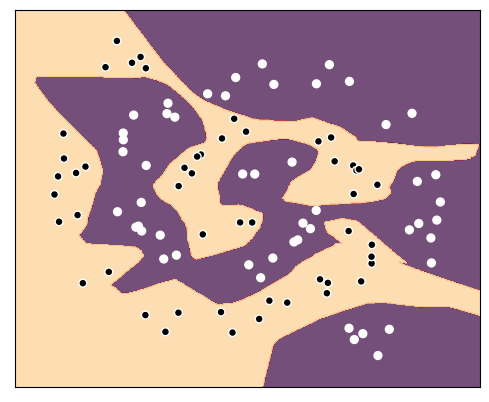

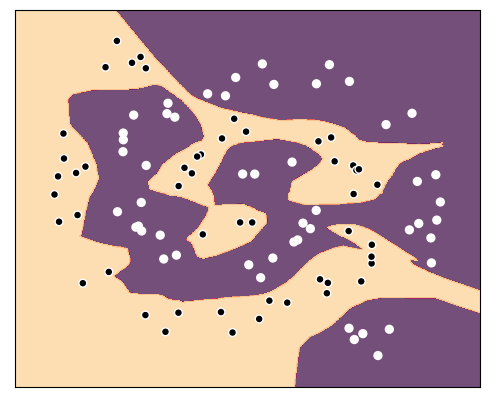

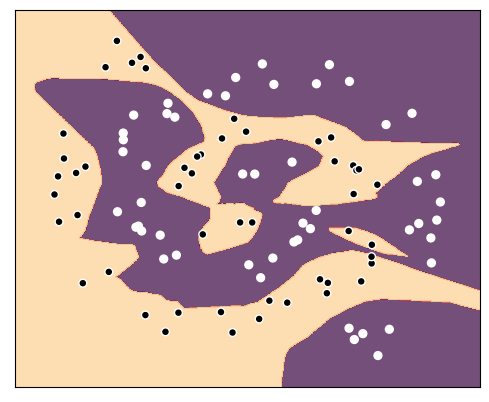

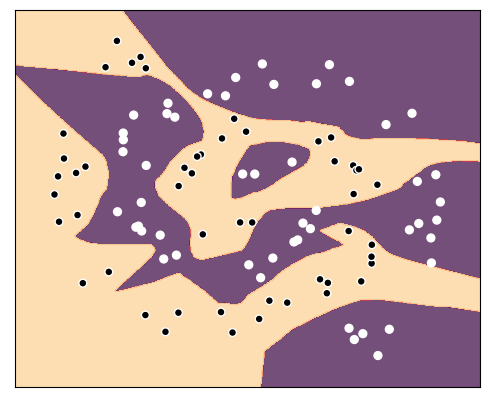

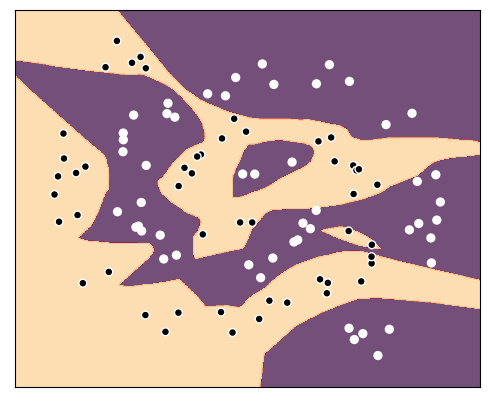

In [261]:
for ii in range(n_mdls):
    fig, ax = plt.subplots(dpi=100, figsize=(6,5))
    plt.contourf(xx, yy, pred_fields[ii, :].cpu().round(),
                cmap=lightcmap)

    plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
               s=32, edgecolor='white')
#     rect = patches.Rectangle((-3.5,-6),5, 5,linewidth=3,edgecolor='orange',facecolor='none')
#     ax.add_patch(rect)
    
#     rect = patches.Rectangle((-2,2.),6, 4,linewidth=3,edgecolor='orange',facecolor='none')
#     ax.add_patch(rect)
    plt.xticks([])
    plt.yticks([])
#     plt.xlim(-7, 7)
#     plt.ylim(-7, 7)
    plt.savefig("./mdl_" + str(ii) + ".pdf", bbox_inches='tight')
    plt.show()

## Ensemble

In [262]:
n_mdls = 100
ens_preds = torch.zeros(in_grid.shape[0], requires_grad=False)

with torch.no_grad():
    for mdl in range(n_mdls):
        ens_preds += simplex_model(in_grid.cuda()).squeeze().cpu()
    
ens_preds = ens_preds.div(n_mdls)

In [263]:
avg_preds = torch.sigmoid(ens_preds.reshape(xx.shape).detach().cpu())

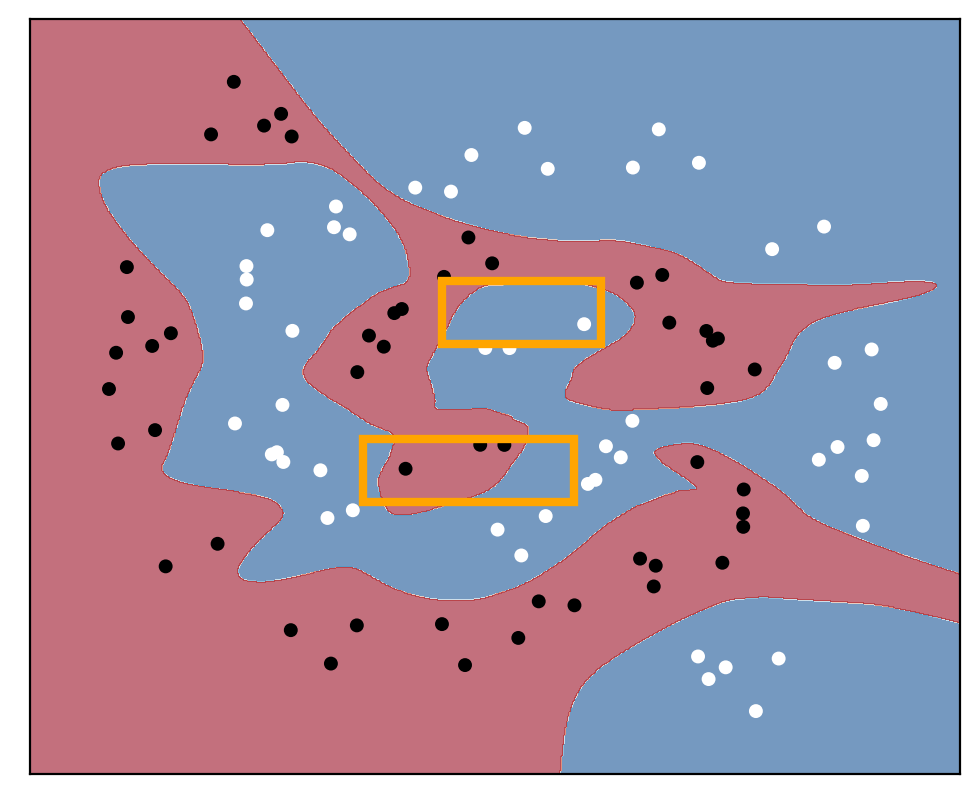

In [264]:
fig, ax = plt.subplots(dpi=200, figsize=(6,5))
plt.contourf(xx, yy, avg_preds.cpu().round(), alpha=0.6,
            cmap='RdBu_r')
# plt.title("Temp Scaled", fontsize=24)
# plt.colorbar()
rect = patches.Rectangle((-5,-5),8, 3,linewidth=3,edgecolor='orange',facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((-2,2.5),6, 3,linewidth=3,edgecolor='orange',facecolor='none')
ax.add_patch(rect)
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
           s=16)
# plt.xlim(-7, 7)
# plt.ylim(-7, 7)
plt.xticks([])
plt.yticks([])
plt.savefig("./ensemble.pdf", bbox_inches='tight')
plt.show()